In [2]:
"""Calculate pCls based on mocks"""

import numpy as np
import pandas as pd
import healpy as hp
from astropy.io import fits
import pyccl as ccl

from tqdm import tqdm #for timing

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-notebook")

import sys
sys.path.insert(1, '/home/tanveer/Documents/desi-planck-cross-corr/imaging-sys-covariance/src/')
from lib import *

#list of all selection function fits files
import glob
flist = glob.glob("/home/tanveer/Documents/desi-planck-cross-corr/imaging-sys-covariance/dat/windows_1000mocks/*fits")

#plotting parameters
fs = 20 #font size
fsize = (10, 7) #figure size

#cosmology and simulation parameters
NSIDE = 1024
LMIN = 100;
LMAX = 3 * NSIDE - 1
ell = np.arange(0, LMAX, 1)
ELL = np.logspace(0, np.log10(LMAX), 10) #for binning

h = 0.6736
Omega_c = 0.12/h**2
Omega_b = 0.02237/h**2
A_s = 2.083e-09
n_s = 0.9649
b1 = 1.75

NMOCKS = 10
tol = 0.8 #define tolerance between window and mask divergence

#noise parameters
nbar_sqdeg = 2400 #per deg2
nbar_sr = (np.pi/180)**(-2) * nbar_sqdeg #conversion factor from sq deg to sr
cls_shot_noise = 1/nbar_sr * np.ones_like(ell)

#read in random and degrade it to generate mask
dr_elg_ran = np.load("../dat/elg_ran1024.npy")
#dr_elg_ran64 = hp.ud_grade(dr_elg_ran, 64) #make it very coarse to remove weird effects in the middle
#dr_elg_ran_final = hp.ud_grade(dr_elg_ran64, NSIDE) #leave as be for stellar masks

mask = np.copy(dr_elg_ran)
mask[dr_elg_ran != 0] = 1 #good pixels are 1
mask = mask.astype("bool")

#import avg map
Favg_map = np.load("../dat/windows_1000mocks/Favg/Favg_map.npy")

#set theory Cls
cls_elg_th = cgll(ell = ell, bias = b1, Omega_c = Omega_c,
                    Omega_b = Omega_b, h = h, A_s = A_s, n_s = n_s)

##MAIN PART OF THE CODE##

#print("Which model do you want to calculate?")
expname = input() #Look at notebook for definitions
#expname = sys.argv[1]
#expname = 'A'
print("Running Model " + expname)

cls_obs = np.zeros((NMOCKS, LMAX)) #pCl values
noise_window = np.zeros(NMOCKS) #selection function noise
fsky = np.zeros(NMOCKS)

#set const. fsky and noise_window; fsky same in the first three models
if((expname == 'A')):
    fsky = np.sum(mask)/mask.shape[0] * np.ones(NMOCKS)
    noise_window = np.mean(Favg_map)*1/nbar_sr*np.ones(NMOCKS)
    tmpF = Favg_map #since fixed window set outside loop
    additive = None
    img_applied_data = False
elif((expname == 'B') | (expname == 'C')):
    fsky = np.sum(mask)/mask.shape[0] * np.ones(NMOCKS)
    img_applied_data = False
elif(expname == 'D'):
    mask = mask & (Favg_map > tol)
    fsky = np.sum(mask)/mask.shape[0] * np.ones(NMOCKS)
    noise_window = np.mean(1/Favg_map[mask]) * 1/nbar_sr * np.ones(NMOCKS)
    tmpF = Favg_map #since fixed window set outside loop

#model conditions; window applied to data vs random
if((expname == 'A') | (expname == 'B') | (expname == 'C')):
    img_applied_data = False
else:
    img_applied_data = True

#model conditions; additive component
if((expname == 'C') | (expname == 'F')):
    additive = Favg_map
else:
    additive = None

#loop over mocks to calculate pCl
for i in range(NMOCKS):

    #read in sel. function
    if((expname != 'A') | (expname != 'D')):
        print(expname)
        tmpF = read_img_map(flist[i])

        #renormalize selection function such that <F> = 1.
        masked_tmpF_mean = np.mean(tmpF[mask > 0])
        tmpF /= masked_tmpF_mean

    #set mask for E and F
    if((expname == 'E') | (expname == 'F')):
        mask = mask & (tmpF > tol)
        fsky[i] = np.sum(mask)/mask.shape[0]
        noise_window[i] = np.mean(1/tmpF[mask]) * 1/nbar_sr
    elif((expname == 'B') | (expname == 'C')):
        noise_window[i] = np.mean(tmpF)*1/nbar_sr

    #calculate pCl
    cls_obs[i] = cls_from_mock(cls_th = cls_elg_th,
                cls_shot_noise=cls_shot_noise, F = tmpF,
                mask = mask, seed = 67 + 2*i, LMAX = LMAX, additive = additive,
                img_applied_data = img_applied_data)

    if((i % (100)) == 0):
        print(i)

#first order correction to pCls; fsky and noise_window
if((expname == 'A') | (expname == 'B') | (expname == 'C')):
    cls_obs = (cls_obs - noise_window[:,np.newaxis])/fsky[:,np.newaxis]
else:
    cls_obs = cls_obs/fsky[:,np.newaxis] - noise_window[:,np.newaxis]

#store values
#np.save("../dat/pCls/1000mocks/pCls_" + expname + ".npy", cls_obs)
#np.save("../dat/pCls/1000mocks/noise_window_" + expname + ".npy", noise_window)
#np.save("../dat/pCls/1000mocks/fsky_" + expname + ".npy", fsky)

Running Model A
A
0
A


KeyboardInterrupt: 

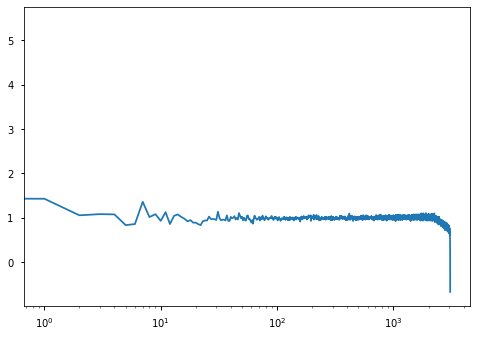

In [7]:
plt.semilogx(cls_obs.mean(axis = 0)/cls_elg_th)

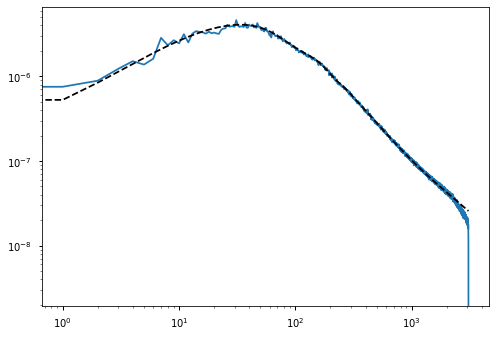

In [8]:
plt.loglog(cls_obs.mean(axis = 0))
plt.loglog(cls_elg_th, c = 'k', ls = '--')

In [10]:
print(fsky.shape)
print(noise_window.shape)
print(cls_obs.shape)

(1000,)
(1000,)
(1000, 3071)
